In [2]:
import ee
import folium
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())
from IPython.display import Image




Successfully saved authorization token.
NASADEM: NASA NASADEM Digital Elevation 30m


In [14]:
ee.Initialize()

# Define os pontos de interesse (longitude, latitude)
point1 = ee.Geometry.Point([-54.623270, -8.470986])

# Carrega a coleção de imagens Sentinel-2 Surface Reflectance
s2Sr = ee.ImageCollection('COPERNICUS/S2_SR')

# Filtra a coleção para o ponto de interesse 1
img1 = s2Sr.filterBounds(point1).first()

# Seleciona a banda SCL (Scene Classification Band)
scl = img1.select('SCL')

# Criação de máscaras binárias para diferentes tipos de nuvens
cloud_shadow = scl.eq(3)
cloud_low = scl.eq(7)
cloud_medium = scl.eq(8)
cloud_high = scl.eq(9)

# Mesclando as máscaras
cloud_mask = cloud_shadow.Or(cloud_low).Or(cloud_medium).Or(cloud_high)

# Criando uma imagem de máscara binária a partir da imagem de máscara binária, substituindo o preto por nulos
cloud_uni = cloud_mask.eq(0).selfMask()

# Finalmente, aplicando a máscara à imagem original
cloud_masked = img1.updateMask(cloud_uni)

# Convertendo a imagem mascarada para um formato que o Folium pode exibir
url = cloud_masked.getThumbURL({
    'min': 1251, 'max': 6001, 'gamma': 1.6,
    'bands': ['B4', 'B3', 'B2'],
    'dimensions': 512  # Adjust the dimensions to a smaller size
})

folium.Map(location=[-8.470986, -54.623270], zoom_start=11, tiles="Stamen Terrain").add_child(folium.ImageOverlay(url, bounds=[[cloud_masked.geometry().bounds().get(1), cloud_masked.geometry().bounds().get(0)], [cloud_masked.geometry().bounds().get(3), cloud_masked.geometry().bounds().get(2)]])).add_to(Map)

# Exibindo o mapa

display(Map)

ValueError: Custom tiles must have an attribution.

In [29]:
ee.Initialize()

# Carrega a coleção de imagens Sentinel-2 Surface Reflectance
s2Sr = ee.ImageCollection('COPERNICUS/S2_SR')
# Filtra a coleção para o ponto de interesse 1
img1 = s2Sr.filterBounds(folium.Map).first()
# Convertendo a imagem mascarada para um formato que o Folium pode exibir
url = cloud_masked.getThumbURL({
    'min': 100, 'max': 1200, 'gamma': 1.6,
    'bands': ['B4', 'B3', 'B2'],
    'dimensions': 512  # Adjust the dimensions to a smaller size
})

# Criando um mapa Folium com camada de imagem e usando os tiles padrão do OpenStreetMap
m = folium.Map(location=[-8.470986, -54.623270], zoom_start=11, tiles='OpenStreetMap')

# Obtendo as coordenadas do bounding box
bbox = cloud_masked.geometry().bounds().getInfo()

# Adicionando a camada de imagem ao mapa
folium.raster_layers.ImageOverlay(
    image=url,
    bounds=[[bbox['coordinates'][0][1], bbox['coordinates'][0][0]],
           ],
    opacity=1,
    name='Cloud Masked Image'
).add_to(m)

# Adicionando controle de camadas ao mapa
folium.LayerControl().add_to(m)

# Exibindo o mapa
display(m)


IndexError: list index out of range

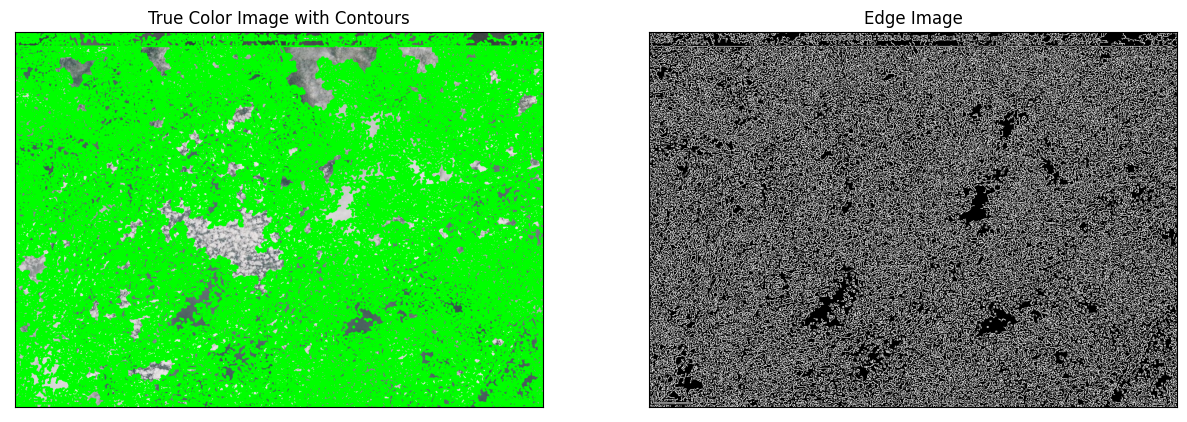

In [34]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Read the image in color
img = cv.imread('2023-02-07-00_00_2023-02-07-23_59_Sentinel-2_L1C_True_color (1).jpg', cv.IMREAD_COLOR)

# Check if the image is read successfully
assert img is not None, "File could not be read, check with os.path.exists()"

# Convert BGR to RGB (OpenCV uses BGR by default)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Convert the image to grayscale for edge detection
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv.Canny(gray_img, 20, 40)

# Find contours
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv.drawContours(img_rgb, contours, -1, (0, 255, 0), 2)

# Set the figure size
plt.figure(figsize=(15, 5))

# Display the true color image with contours
plt.subplot(121), plt.imshow(img_rgb)
plt.title('True Color Image with Contours'), plt.xticks([]), plt.yticks([])

# Display the edge image
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()


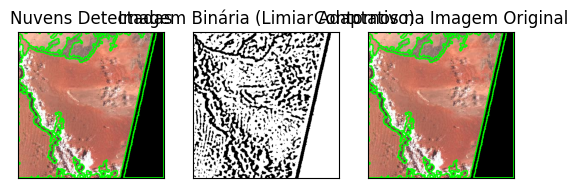

In [36]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Ler a imagem em cores
img = cv.imread('S2A_MSIL1C_20161221T085352_N0204_R107_T33KWP_20161221T091140-ql.jpg', cv.IMREAD_COLOR)

# Verificar se a imagem foi lida com sucesso
assert img is not None, "O arquivo não pôde ser lido. Verifique com os.path.exists()"

# Converter BGR para RGB
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Aplicar filtro Gaussiano para redução de ruído
img_filtered = cv.GaussianBlur(img_rgb, (9, 9), 0)  # Aumente o tamanho do kernel para um filtro mais suave

# Converter a imagem para escala de cinza
gray_img = cv.cvtColor(img_filtered, cv.COLOR_RGB2GRAY)

# Limiarização adaptativa para destacar nuvens
binary_img = cv.adaptiveThreshold(gray_img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)

# Encontrar contornos
contours, _ = cv.findContours(binary_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filtrar contornos com base em área
min_contour_area = 500
cloud_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_contour_area]

# Desenhar contornos na imagem original
cv.drawContours(img_rgb, cloud_contours, -1, (0, 255, 0), 2)

# Exibir resultados
plt.subplot(131), plt.imshow(img_rgb)
plt.title('Nuvens Detectadas'), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(binary_img, cmap='gray')
plt.title('Imagem Binária (Limiar Adaptativo)'), plt.xticks([]), plt.yticks([])

# Exibir imagem original para análise
plt.subplot(133), plt.imshow(img_rgb)
plt.title('Contornos na Imagem Original'), plt.xticks([]), plt.yticks([])

plt.show()
